In [3]:
#### Reference paper https://arxiv.org/abs/1808.08219




import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import scipy.optimize as optimize
from scipy.optimize import root_scalar
from adaptive_integrator import integrate
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


 
def j_fdm(t, y, gamma):
    r, dydtau = y
    dydtau2 = (2 * gamma - gamma**2)/(4 * (r**3)) - (1/(r**2)) - r/(4 * (t**2))
    return [dydtau, dydtau2]


def j_cdm(t, y):
    r, dydtau = y
    dydtau2 =  - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]


# Full analytic turnaround radius
def r_turnaround_full(tau, gamma): 
    def expression(y_ta):
        return y_ta**4 - 4 * y_ta * (tau**2) + (2 * gamma - gamma**2) * (tau**2)
    factor = 0.635 * (1 + 0.01 * np.log10(1 + gamma))
    #print(factor)
    r_ta_initial = factor * (8 * (tau**2))**(1/3)
    sol = optimize.fsolve(expression, r_ta_initial, xtol=1e-10)[0]
    return sol





# Event function for maximum (dy/dtau = 0)
def event_y_max(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_max.terminal = False  # Do not stop integration here
event_y_max.direction = -1    # Detect decreasing slope (peak reached)
# Event function for minimum (dy/dtau = 0 after y_max)
def event_y_min(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_min.terminal = True   # Stop integration here
event_y_min.direction = 1     # Detect increasing slope (trough reached)




def y_fdm_full(gamma):
    solutions = []
    turnaround_points = []
    for y_i in yi_values:
        v_i = y_i / (2 * tau_i)
        y0 = [y_i, v_i]
        tau_arr = np.geomspace(tau_i, tau_f, 10000)
        sol = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), 
                        method='RK45', t_eval=tau_arr, 
                        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])
        solutions.append((sol.t, sol.y[0], y_i))
        if sol.t_events[0].size > 0:
            tau_ta = sol.t_events[0][0]
            y_ta = sol.y_events[0][0][0]
            turnaround_points.append((tau_ta, y_ta, y_i))  
    return solutions, turnaround_points




def j_fdm_hubble(t, y, gamma):
    r, dydtau = y
    dydtau2 = -r / (4 * (t**2))
    return [dydtau, dydtau2]



def j_fdm_pbh(t, y, gamma, tau_i, y_i):
    r, dydtau = y
    b = 1e-30  # Small number to prevent division by zero
    A = tau_i / (y_i**2 + b**2)
    B = ((2 * gamma - gamma**2) * (tau_i**(3/2))) / (4 * (y_i**3 + b**3))
    dydtau2 = - (A / t) + (B / (t**(3/2)))
    return [dydtau, dydtau2]





def y_full_perturbed(gamma):
    solutions = []
    turnaround_points = []

    for y_i in yi_values:
        tau_arr = np.geomspace(tau_i, tau_f, 10000)
        v_i = y_i / (2 * tau_i)
        y0 = [y_i, v_i]

        sol_fdm_hubble = solve_ivp(j_fdm_hubble, [tau_i, tau_f], y0, args=(gamma,),
                                   t_eval=tau_arr, method='RK45', rtol=1e-6, atol=1e-8)
        sol_fdm_pbh = solve_ivp(j_fdm_pbh, [tau_i, tau_f], [0, 0], args=(gamma, tau_i, y_i,),
                                t_eval=tau_arr, method='RK45', rtol=1e-6, atol=1e-8)
        t_total = sol_fdm_pbh.t
        y_total = sol_fdm_hubble.y[0] + sol_fdm_pbh.y[0]
        v_total = sol_fdm_hubble.y[1] + sol_fdm_pbh.y[1]
        turnaround_idx = np.where(v_total < 0)[0]
        if len(turnaround_idx) > 0:
            tau_ta = sol_fdm_pbh.t[turnaround_idx[0]]
            y_ta = y_total[turnaround_idx[0]]
        else:
            tau_ta, y_ta = tau_f, y_total[-1]
        solutions.append((t_total, y_total, y_i))
        turnaround_points.append((tau_ta, y_ta, y_i))
    return solutions, turnaround_points



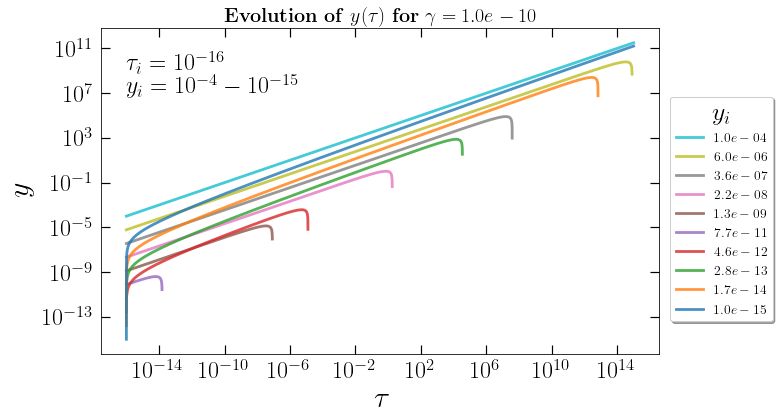

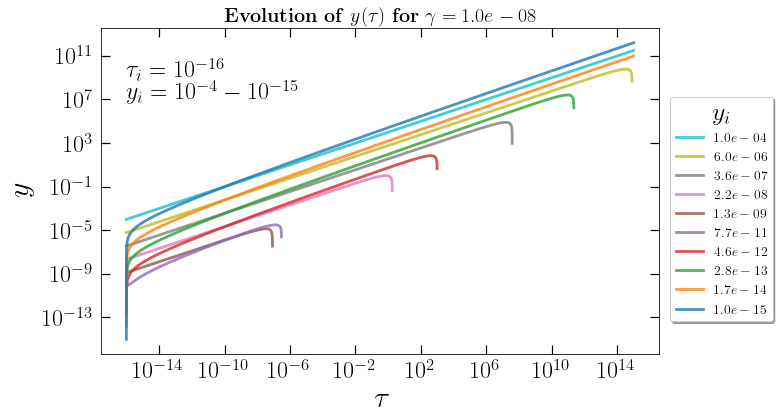

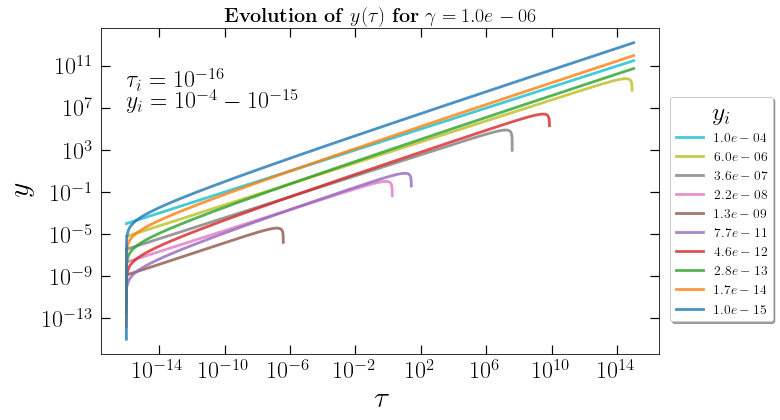

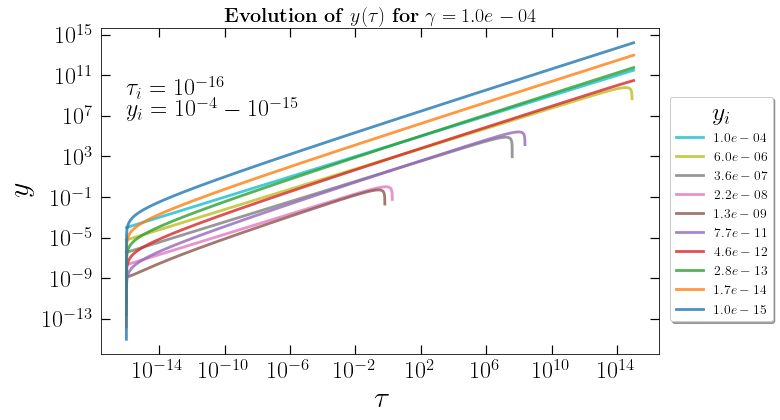

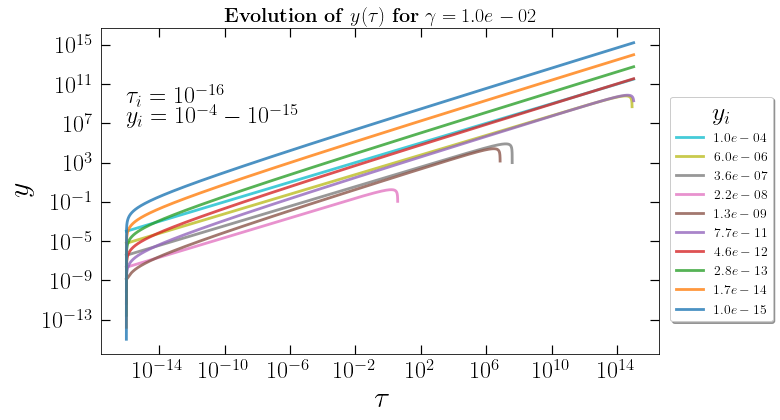

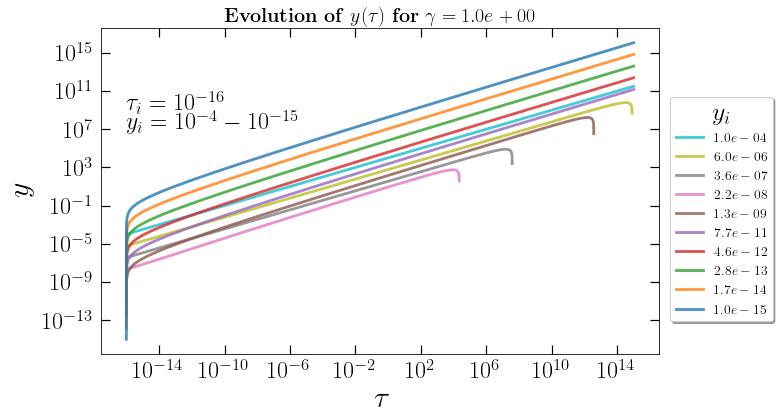

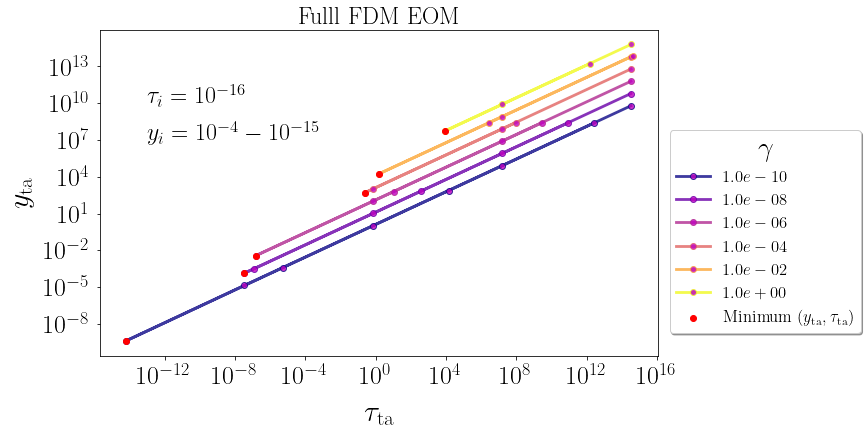

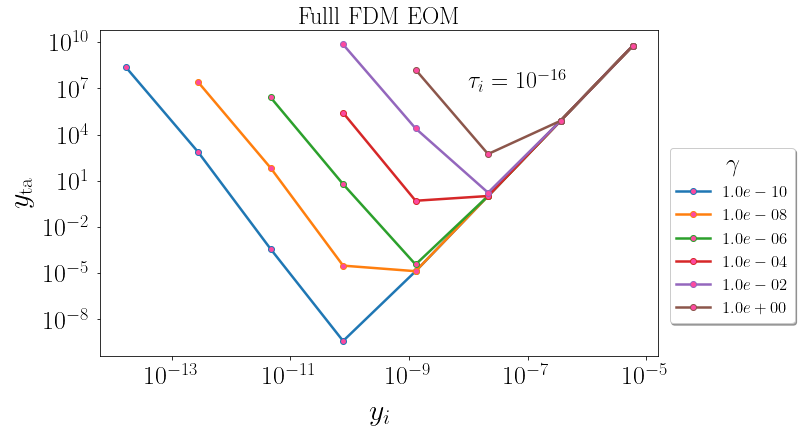

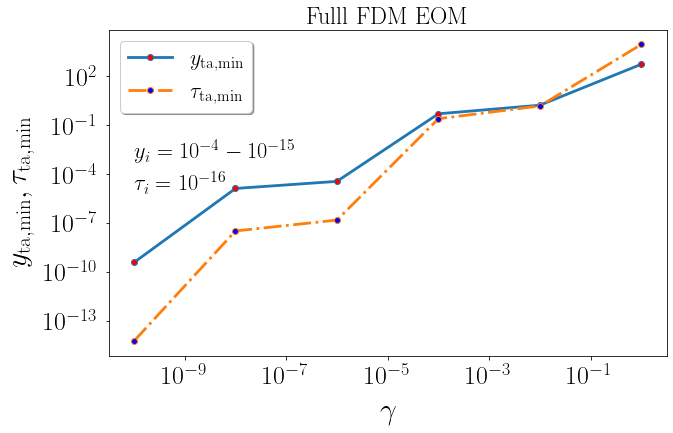

Minimum values of the turnraound points for each gamma :-
Gamma: 1.0e-10, Y_i: 7.7426e-11, Tau_ta_numerical: 6.2100e-15, Y_ta_numerical: 4.0057e-10, Y_ta_analytical: 5.1848e-10
Gamma: 1.0e-08, Y_i: 1.2915e-09, Tau_ta_numerical: 3.4184e-08, Y_ta_numerical: 1.3644e-05, Y_ta_analytical: 1.6718e-05
Gamma: 1.0e-06, Y_i: 1.2915e-09, Tau_ta_numerical: 1.5814e-07, Y_ta_numerical: 3.7167e-05, Y_ta_analytical: 4.6252e-05
Gamma: 1.0e-04, Y_i: 1.2915e-09, Tau_ta_numerical: 2.5585e-01, Y_ta_numerical: 5.1205e-01, Y_ta_analytical: 6.3974e-01
Gamma: 1.0e-02, Y_i: 2.1544e-08, Tau_ta_numerical: 1.5426e+00, Y_ta_numerical: 1.7205e+00, Y_ta_analytical: 2.1177e+00
Gamma: 1.0e+00, Y_i: 2.1544e-08, Tau_ta_numerical: 9.0309e+03, Y_ta_numerical: 5.5363e+02, Y_ta_analytical: 6.8832e+02


In [8]:
# Numerically, directly solving the full EOM of FDM  to find out 
# the minimum values of yta_min and tau_ta_min for each gamma. 



gamma_values = np.geomspace(1e-10, 1, 6) 
yi_values = np.geomspace(1e-4, 1e-15, 10)  
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



gamma_results = {gamma: y_fdm_full(gamma) for gamma in gamma_values}
#min_turnaround_pts = [(gamma, *min(gamma_results[gamma][1], key=lambda x: x[1])) 
                      #for gamma in gamma_values]
# Find minimum turnaround points
min_turnaround_pts = []
for gamma in gamma_values:
    _, turnaround_points = gamma_results[gamma]
    if turnaround_points:  
        all_y_ta = [yta for _, yta, _ in turnaround_points]  # Extract all turnaround points
        min_idx = np.argmin(all_y_ta)  # Find index of smallest y_ta
        min_tau_ta, min_y_ta, min_yi_ta = turnaround_points[min_idx]
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

        
gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))  



#plotting y vs tau for different values of gamma, each with different values of y_i
for i, (gamma, (solutions, _)) in enumerate(gamma_results.items()):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

    for j, ((tau_vals, y_vals, y_i), color) in enumerate(zip(solutions, colors * (len(solutions) // len(colors) + 1))):
        ax1.loglog(tau_vals, y_vals, color=color, alpha=0.8, label=f"${y_i:.1e}$")
    
    plt.text(tau_i, 1e9, r'$\tau_i = 10^{-16}$', fontsize=24)
    plt.text(tau_i, 1e7, r'$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              facecolor='white', fontsize=12)
    #plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()



    
    
#plotting (y_ta, tau_ta) points for different values of gamma (each with different values of y_i)
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, turnaround_points)) in enumerate(gamma_results.items()): 
    tau_ta, y_ta, yi_ta = zip(*turnaround_points)  
    y_ta_scaled = [y * 10**i for y in y_ta] 
    ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], label=f"${gamma:.1e}$", marker='o', markersize=6, markerfacecolor='m', alpha=0.8)

    
    
#gamma_arr,  min_tau_arr, min_y_arr, min_yi_arr = zip(*min_turnaround_pts)
gamma_arr, min_yi_arr, min_tau_arr, min_y_arr = zip(*min_turnaround_pts)
min_y_arr_scaled = [y * 10**i for i, y in enumerate(min_y_arr)]
ax2.scatter(min_tau_arr, min_y_arr_scaled, color='r', zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

plt.text(1e-13, 1e7, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-13, 1e10, r'$\tau_i = 10^{-16}$', fontsize=24)
ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
#ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.set_title('Fulll FDM EOM', fontsize=24)

ax2.legend(prop={'size':16.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=28,
           facecolor='white', fontsize=12)
plt.savefig("yta_vs_tauta_full.pdf", bbox_inches='tight')
plt.show()



#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, turnaround_points)) in enumerate(gamma_results.items()):
    tau_ta , y_ta,  yi_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=6, markerfacecolor='#fd49a0', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")

    
#plt.text(1e-8, 1e9, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-8, 1e7, r'$\tau_i = 10^{-16}$', fontsize=24)
ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax3.set_xlabel(r'$y_i$', fontsize=30, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
#ax3.set_title(r'$y_i$ vs. $y_\mathrm{ta}$ for Different $\gamma$', fontsize=24)
ax3.set_title('Fulll FDM EOM', fontsize=24)

ax3.legend(prop={'size':16.7}, loc=(1.02, 0.1), shadow=True, title=r'$\gamma$', title_fontsize=25,
           facecolor='white', fontsize=12)
plt.savefig("yi_vs_yta_full.pdf", bbox_inches='tight')
plt.show()



# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#gamma_arr, min_tau_arr, min_y_arr,  min_yi_arr = zip(*min_turnaround_pts)
gamma_arr, min_yi_arr, min_tau_arr, min_y_arr = zip(*min_turnaround_pts)

ax4.loglog(gamma_arr, min_y_arr, marker='o', markersize=6, markerfacecolor='r',ls = '-')
ax4.loglog(gamma_arr, min_tau_arr,  marker='o', markersize=6, markerfacecolor='b', ls = '-.')

plt.text(1e-10, 1e-3, '$y_i = 10^{-4} - 10^{-15}$', fontsize=22.5)
plt.text(1e-10, 1e-5, r'$\tau_i = 10^{-16}$', fontsize=22.5)



ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min}$", r"$\tau_\mathrm{ta, min}$"], prop={'size':22}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
ax4.set_title('Fulll FDM EOM', fontsize=24)

plt.savefig("ytamin_vs_gamma_full.pdf", bbox_inches='tight')
plt.show()

gamma_arr, min_yi_arr, min_tau_arr, min_y_arr = zip(*min_turnaround_pts)
yta_analytical_arr = np.zeros(len(gamma_arr))
for i, (gamma, min_tau) in enumerate(zip(gamma_arr, min_tau_arr)):
    yta_analytical_arr[i] = r_turnaround_full(min_tau, gamma)

min_turnaround_pts = list(zip(gamma_arr, min_yi_arr, min_tau_arr, min_y_arr, yta_analytical_arr))
print('Minimum values of the turnraound points for each gamma :-')
for gamma, min_yi, min_tau, min_y, y_ta_ana in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {min_yi:.4e}, Tau_ta_numerical: {min_tau:.4e}, Y_ta_numerical: {min_y:.4e}, Y_ta_analytical: {y_ta_ana:.4e}")

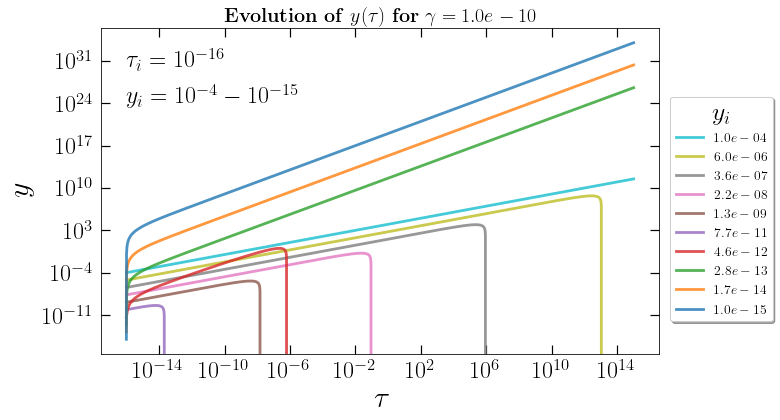

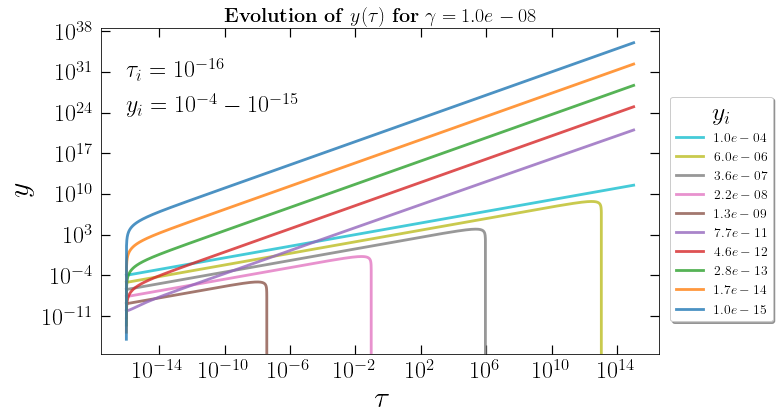

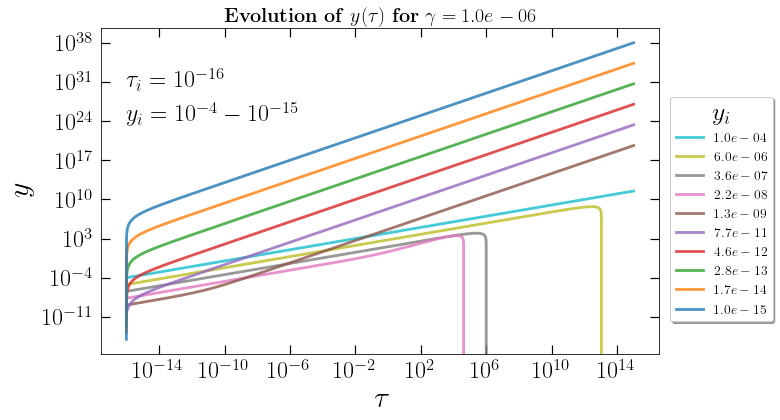

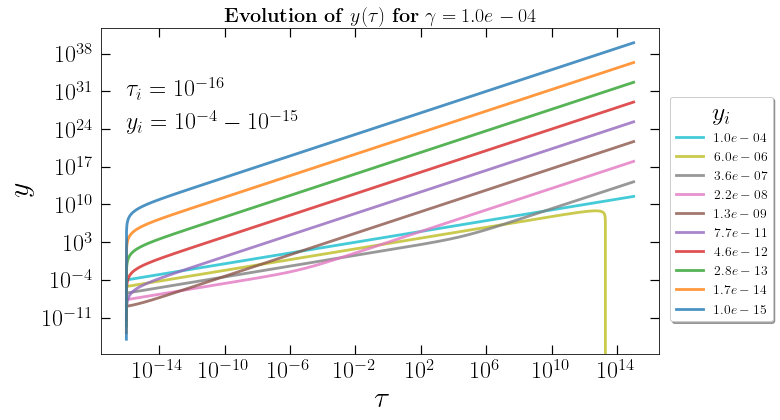

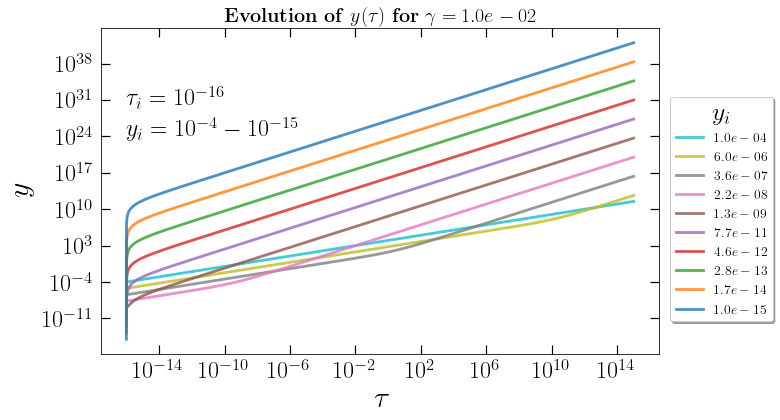

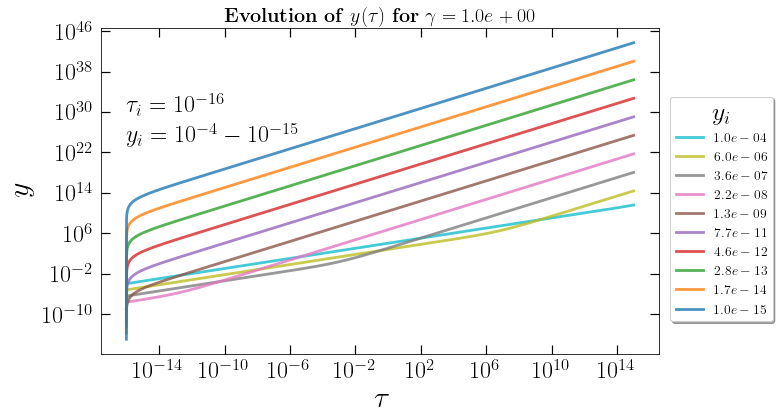

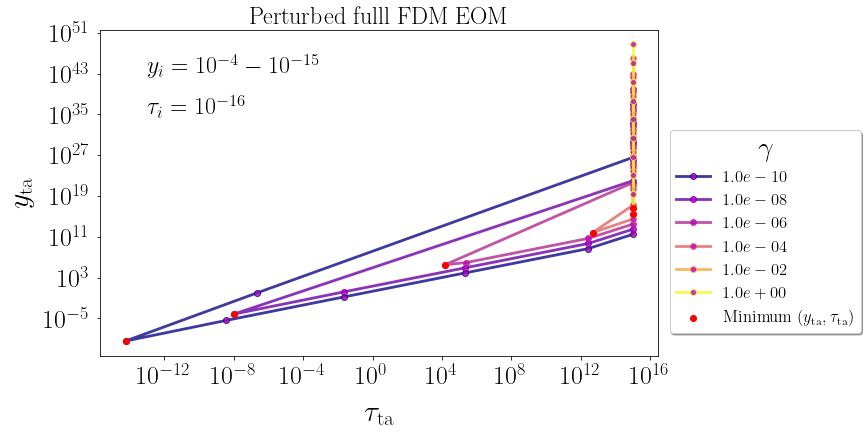

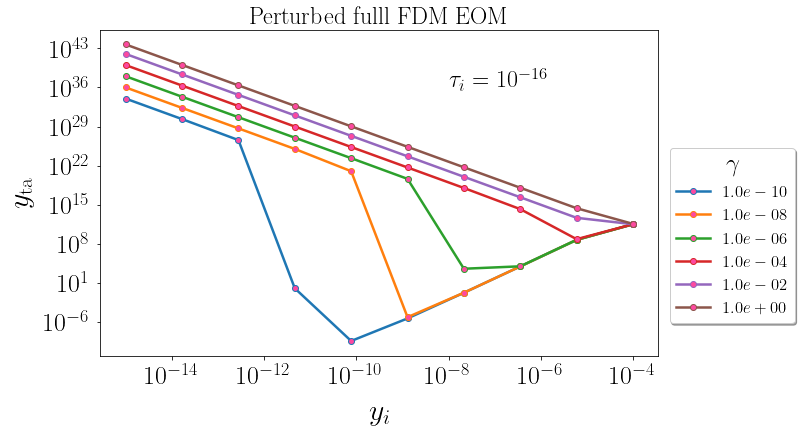

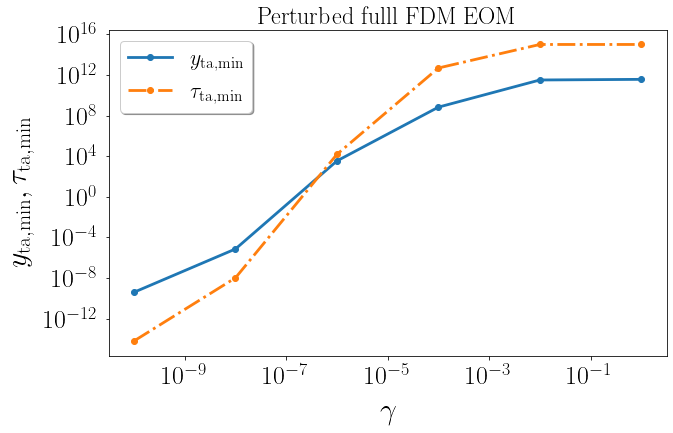

Minimum values of the turnraound points for each gamma :-
Gamma: 1.0e-10,  Tau_ta_numerical: 6.1063e-15, Y_ta_numerical: 3.8642e-10, Y_i: 7.7426e-11
Gamma: 1.0e-08,  Tau_ta_numerical: 1.0188e-08, Y_ta_numerical: 7.1119e-06, Y_i: 1.2915e-09
Gamma: 1.0e-06,  Tau_ta_numerical: 1.5025e+04, Y_ta_numerical: 3.3617e+03, Y_i: 2.1544e-08
Gamma: 1.0e-04,  Tau_ta_numerical: 4.7970e+12, Y_ta_numerical: 6.6717e+08, Y_i: 5.9948e-06
Gamma: 1.0e-02,  Tau_ta_numerical: 1.0000e+15, Y_ta_numerical: 3.1698e+11, Y_i: 1.0000e-04
Gamma: 1.0e+00,  Tau_ta_numerical: 1.0000e+15, Y_ta_numerical: 3.6545e+11, Y_i: 1.0000e-04


In [7]:
# Numerically, solving the perturbed full EOM of FDM to find out 
# the minimum values of yta_min and tau_ta_min for each gamma. 


gamma_results = {}
for gamma in gamma_values:
    solutions, turnaround_points = y_full_perturbed(gamma)
    gamma_results[gamma] = (solutions, turnaround_points)

min_turnaround_pts = [(gamma, *min(turnaround_points, key=lambda x: x[1]))  
    for gamma, (_, turnaround_points) in gamma_results.items() if turnaround_points]
gamma_arr, min_tau_arr, min_y_arr, min_yi_arr = zip(*min_turnaround_pts)

    
    

    
    
#plotting y vs tau for different values of gamma, each with different values of y_i
for i, (gamma, (solutions, _)) in enumerate(gamma_results.items()):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

    for j, ((tau_vals, y_vals, y_i), color) in enumerate(zip(solutions, colors * (len(solutions) // len(colors) + 1))):
        ax1.loglog(tau_vals, y_vals, color=color, alpha=0.8, label=f"${y_i:.1e}$")
    
    plt.text(tau_i, 1e30, r'$\tau_i = 10^{-16}$', fontsize=24)
    plt.text(tau_i, 1e24, r'$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
               facecolor='white', fontsize=12)
    #plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()



#plotting (y_ta, tau_ta) points for different values of gamma (each with different values of y_i)
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, turnaround_points)) in enumerate(gamma_results.items()): 
    tau_ta, y_ta, yi_ta = zip(*turnaround_points)  
    y_ta_scaled = [y * 10**i for y in y_ta] 
    ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], label=f"${gamma:.1e}$", marker='o', markersize=6, markerfacecolor='m', alpha=0.8)

    
    
gamma_arr, min_tau_arr, min_y_arr, min_yi_arr = zip(*min_turnaround_pts)
min_y_arr_scaled = [y * 10**i for i, y in enumerate(min_y_arr)]
ax2.scatter(min_tau_arr, min_y_arr_scaled, color='r', zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

plt.text(1e-13, 1e43, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-13, 1e35, r'$\tau_i = 10^{-16}$', fontsize=24)
ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_title('Perturbed fulll FDM EOM', fontsize=24)

#ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.legend(prop={'size':16.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=28,
           facecolor='white', fontsize=12)
plt.savefig("yta_vs_tauta_perturbed.pdf", bbox_inches='tight')
plt.show()



#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, turnaround_points)) in enumerate(gamma_results.items()):
    tau_ta , y_ta,  yi_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=6, markerfacecolor='#fd49a0', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")

    
#plt.text(1e-8, 1e9, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-8, 1e36, r'$\tau_i = 10^{-16}$', fontsize=24)
ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax3.set_xlabel(r'$y_i$', fontsize=30, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax3.set_title(' Perturbed fulll FDM EOM', fontsize=24)

#ax3.set_title(r'$y_i$ vs. $y_\mathrm{ta}$ for Different $\gamma$', fontsize=24)
ax3.legend(prop={'size':16.7}, loc=(1.02, 0.1), shadow=True, title=r'$\gamma$', title_fontsize=25,
           facecolor='white', fontsize=12)
plt.savefig("yi_vs_yta_perturbed.pdf", bbox_inches='tight')
plt.show()



# 4th Plot: y_ta_min vs gamma
gamma_arr, min_tau_arr, min_y_arr, min_yi_arr = zip(*min_turnaround_pts)
fig4, ax4 = plt.subplots(figsize=(10, 6))
ax4.loglog(gamma_arr, min_y_arr, marker='o', linestyle='-', label=r"$y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tau_arr, marker='o', linestyle='-.', label=r"$\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min}$", r"$\tau_\mathrm{ta, min}$"], prop={'size':22}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
ax4.set_title(' Perturbed fulll FDM EOM', fontsize=24)

plt.savefig("ytamin_vs_gamma_perturbed.pdf", bbox_inches='tight')
plt.show()

min_turnaround_pts = list(zip(gamma_arr, min_tau_arr, min_y_arr, min_yi_arr))
print('Minimum values of the turnraound points for each gamma :-')
for gamma, min_tau, min_y, min_yi in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e},  Tau_ta_numerical: {min_tau:.4e}, Y_ta_numerical: {min_y:.4e}, Y_i: {min_yi:.4e}")